In [116]:
import csv
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
import math

name_dataset = 'mustard_bottle_translation_xyz_roll_yaw_pitch_edopt_test2'

In [117]:
def quaternion_to_euler_angle(w, x, y, z):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """

        roll_list = []
        pitch_list = []
        yaw_list = []

        degrees = 57.2958

        for qx,qy,qz,qw in zip(x,y,z,w):

            t0 = +2.0 * (qw * qx + qy * qz)
            t1 = +1.0 - 2.0 * (qx * qx + qy * qy)
            roll_x = math.atan2(t0, t1)
        
            t2 = +2.0 * (qw * qy - qz * qx)
            t2 = +1.0 if t2 > +1.0 else t2
            t2 = -1.0 if t2 < -1.0 else t2
            pitch_y = math.asin(t2)
        
            t3 = +2.0 * (qw * qz + qx * qy)
            t4 = +1.0 - 2.0 * (qy * qy + qz * qz)
            yaw_z = math.atan2(t3, t4)

            roll_list.append(roll_x*degrees)
            pitch_list.append(pitch_y*degrees)  
            yaw_list.append(yaw_z*degrees)

            roll_array = np.array(roll_list)
            pitch_array = np.array(pitch_list)
            yaw_array = np.array(yaw_list)
     
        return roll_array, pitch_array, yaw_array # in degrees

def cleanEuler(angle, angle_type): 

    # angle = angle[~np.isnan(angle)]
    diff_arrays = angle[1:-1]-angle[0:-2]
    prev_x = 0
    th = 180
    filtered_angles_list = [] 
    diff_list=[]
    for idx, x in enumerate(angle):
        if idx == 0:
            if angle_type==2 and x < 0:
                x+=360 
            prev_x = x
        else:
            diff = abs(x - prev_x)
            diff_list.append(diff)
            if diff > th:
                x += 360
            else:
                if angle_type==2 and x<0:
                    x += 360
            prev_x = x
        filtered_angles_list.append(x)

    return(np.array(filtered_angles_list))

def cleanEuler2(angle_list):
        
    for idx in range(len(angle_list)-1):
        a0 = angle_list[idx]
        a1 = angle_list[idx+1]
        real_val = [a1, a1 + 360, a1 - 360]
        abs_diff = np.abs(real_val-a0)
    
        angle_list[idx+1] = real_val[np.argmin(abs_diff)]
    
    return (np.array(angle_list))

In [118]:
gt_ts = []
gt_x = []
gt_y = []
gt_z = []
gt_qx = []
gt_qy = []
gt_qz = []
gt_qw = []

gt_folder_path = '/data/'+name_dataset+'/photorealistic1/ground_truth.csv'

with open(gt_folder_path, "r") as file:
    reader = csv.reader(file)
    for row in reader:
        gt_ts.append(float(row[0]))
        gt_x.append(float(row[1])*0.01)
        gt_y.append(float(row[2])*0.01)
        gt_z.append(float(row[3])*0.01)
        gt_qx.append(float(row[4]))
        gt_qy.append(float(row[5]))
        gt_qz.append(float(row[6]))
        gt_qw.append(float(row[7]))

gt_ts = np.array(gt_ts) - gt_ts[0]

gt_alpha, gt_beta, gt_gamma = quaternion_to_euler_angle(gt_qw, gt_qx, gt_qy, gt_qz)

# gt_alpha_cleaned = cleanEuler(gt_alpha,0)
# gt_beta_cleaned = cleanEuler(gt_beta,1)
# gt_gamma_cleaned = cleanEuler(gt_gamma,2)

gt_alpha_cleaned = cleanEuler2(gt_alpha)
gt_beta_cleaned = cleanEuler2(gt_beta)
gt_gamma_cleaned = cleanEuler2(gt_gamma)



In [119]:
def compute_aligned_difference(ts1, values1, ts2, values2):
    """
    Interpolates values2 to match timestamps ts1, and computes absolute differences.

    Args:
        ts1 (array-like): Target timestamps.
        values1 (array-like): Values at ts1.
        ts2 (array-like): Source timestamps to interpolate from.
        values2 (array-like): Values at ts2.

    Returns:
        np.array: Absolute difference between values1 and interpolated values2.
    """
    # Interpolate values2 to match timestamps ts1
    interp_func = interp1d(ts2, values2, kind='linear', bounds_error=False, fill_value="extrapolate")
    interpolated_values2 = interp_func(ts1)

    # Compute absolute difference
    differences = np.abs(np.array(values1) - interpolated_values2)

    return differences

def find_first_sustained_exceedance(error, threshold, consecutive_count):
    """
    Find the first index where `consecutive_count` values in a row exceed `threshold`.

    Args:
        error (array-like): Sequence of error values.
        threshold (float): Threshold value.
        consecutive_count (int): Minimum number of consecutive values that must exceed the threshold.

    Returns:
        int or None: Starting index of the first sustained exceedance, or None if not found.
    """
    error = np.array(error) > threshold
    count = 0
    for i, val in enumerate(error):
        if val:
            count += 1
            if count == consecutive_count:
                return i - consecutive_count + 1
        else:
            count = 0
    return None


List has no valid (non-None) values.
None


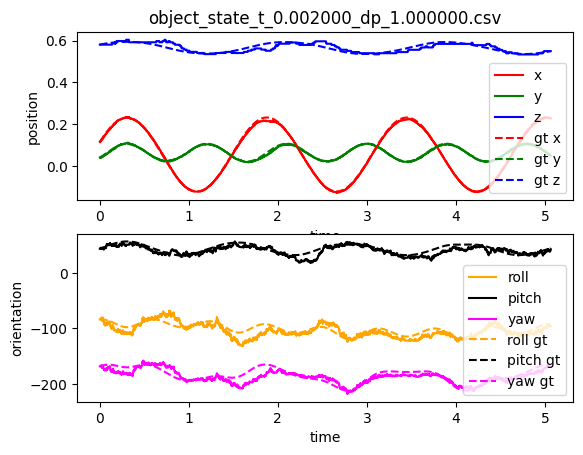

Saved successfully!
List has no valid (non-None) values.
None


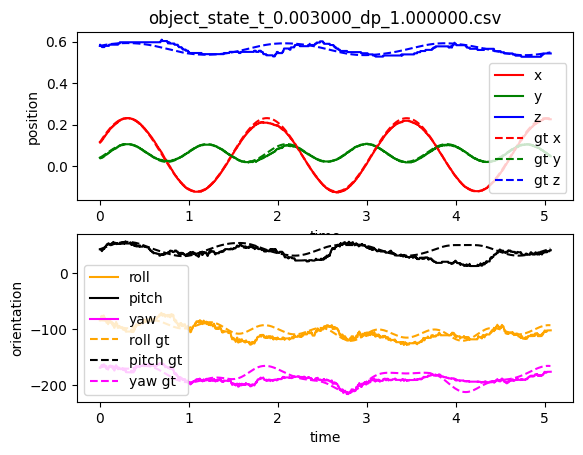

Saved successfully!
Index of the minimum element: 0
451


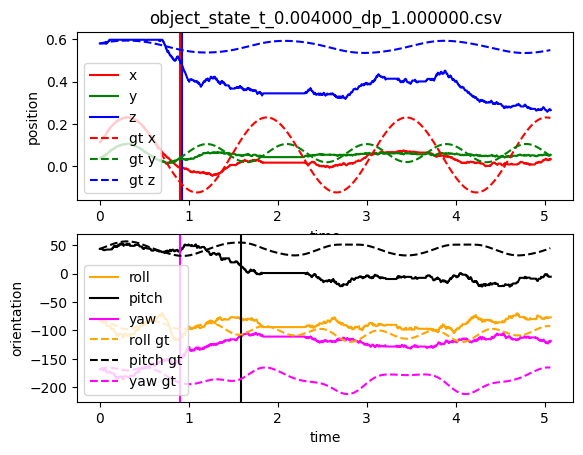

Saved successfully!
[np.float64(5.063632965087891), np.float64(5.063632965087891), np.float64(0.9019346237182617)]


In [120]:
results_folder = '/data/'+name_dataset+'/results/mexican_blur_100:8'
files = sorted([
    f for f in os.listdir(results_folder)
    if os.path.isfile(os.path.join(results_folder, f))
])

failure_times = []

for filename in files:
    ts = []
    x = []
    y = []
    z = []
    qx = []
    qy = []
    qz = []
    qw = []
    time_windows = [1, 2, 3, 4, 5, 6, 10]

    file_path = os.path.join(results_folder, filename)
    with open(file_path, "r") as file:
        reader = csv.reader(file)
        for row in reader:
            ts.append(float(row[0]))
            x.append(float(row[1]))
            y.append(float(row[2]))
            z.append(float(row[3]))
            qx.append(float(row[4]))
            qy.append(float(row[5]))
            qz.append(float(row[6]))
            qw.append(float(row[7]))

        alpha, beta, gamma = quaternion_to_euler_angle(qw, qx, qy, qz)

        # alpha_cleaned = cleanEuler(alpha,0)
        # beta_cleaned = cleanEuler(beta,1)
        # gamma_cleaned = cleanEuler(gamma,2)

        alpha_cleaned = cleanEuler2(alpha)
        beta_cleaned = cleanEuler2(beta)
        gamma_cleaned = cleanEuler2(gamma)

        x_abs_diff = compute_aligned_difference(gt_ts, gt_x, ts, x)
        y_abs_diff = compute_aligned_difference(gt_ts, gt_y, ts, y)
        z_abs_diff = compute_aligned_difference(gt_ts, gt_z, ts, z)

        alpha_abs_diff = compute_aligned_difference(gt_ts, gt_alpha, ts, alpha)
        beta_abs_diff = compute_aligned_difference(gt_ts, gt_beta, ts, beta)
        gamma_abs_diff = compute_aligned_difference(gt_ts, gt_gamma, ts, gamma)

        index_x = find_first_sustained_exceedance(x_abs_diff, 0.07, 50)
        index_y = find_first_sustained_exceedance(y_abs_diff, 0.07, 50)
        index_z = find_first_sustained_exceedance(z_abs_diff, 0.07, 50)

        index_alpha = find_first_sustained_exceedance(alpha_abs_diff, 40, 50)
        index_beta = find_first_sustained_exceedance(beta_abs_diff, 40, 50)
        index_gamma = find_first_sustained_exceedance(gamma_abs_diff, 40, 50)

        indeces = [index_x, index_y, index_z, index_alpha, index_beta, index_gamma]

        # Filter out None values and keep track of original indexes
        filtered = [(i, val) for i, val in enumerate(indeces) if val is not None]

        if filtered:
            min_index = min(filtered, key=lambda x: x[1])[0]
            print("Index of the minimum element:", min_index)
        else:
            print("List has no valid (non-None) values.")
            min_index = 0
        
        if indeces[min_index] == None:
            failure_times.append(gt_ts[-1])
        else:    
            failure_times.append(gt_ts[indeces[min_index]])

        %matplotlib inline

        fig,ax = plt.subplots(2,1)

        ax[0].plot(np.array(ts), np.array(x), label="x", color="red")
        print(index_x)
        if index_x != None:
            ax[0].axvline(x = gt_ts[index_x], color='red')
        if index_y != None:
            ax[0].axvline(x = gt_ts[index_y], color='green')
        if index_z != None:
            ax[0].axvline(x = gt_ts[index_z], color='blue')
        ax[0].plot(np.array(ts), np.array(y), label="y", color="green")
        ax[0].plot(np.array(ts), np.array(z), label="z", color="blue")

        ax[0].plot(gt_ts, np.array(gt_x), label="gt x", color="red", linestyle="dashed")
        ax[0].plot(gt_ts, np.array(gt_y), label="gt y", color="green", linestyle="dashed")
        ax[0].plot(gt_ts, np.array(gt_z), label="gt z", color="blue", linestyle="dashed")

        ax[0].set_xlabel("time")
        ax[0].set_ylabel("position")
        ax[0].legend()

        ax[1].plot(ts, alpha_cleaned, label="roll", color='orange')
        ax[1].plot(ts, beta_cleaned, label="pitch", color='black')
        ax[1].plot(ts, gamma_cleaned, label="yaw", color='magenta')

        # ax[1].plot(ts, qx, label="qx", color='orange')
        # ax[1].plot(ts, qy, label="qy", color='black')
        # ax[1].plot(ts, qz, label="qz", color='magenta')
        # ax[1].plot(ts, qw, label="qw", color='grey')

        if index_alpha != None:
            ax[1].axvline(x = gt_ts[index_alpha], color='orange')
        if index_beta != None:
            ax[1].axvline(x = gt_ts[index_beta], color='black')
        if index_gamma != None:
            ax[1].axvline(x = gt_ts[index_gamma], color='magenta')

        ax[1].plot(gt_ts, gt_alpha_cleaned, label="roll gt", color='orange', linestyle="dashed")
        ax[1].plot(gt_ts, gt_beta_cleaned, label="pitch gt", color='black', linestyle="dashed")
        ax[1].plot(gt_ts, gt_gamma_cleaned, label="yaw gt", color='magenta', linestyle="dashed")

        # ax[1].plot(gt_ts, gt_qx, label="qx gt", color='orange', linestyle="dashed")
        # ax[1].plot(gt_ts, gt_qy, label="qy gt", color='black', linestyle="dashed")
        # ax[1].plot(gt_ts, gt_qz, label="qz gt", color='magenta', linestyle="dashed")
        # ax[1].plot(gt_ts, gt_qw, label="qw gt", color='grey', linestyle="dashed")

        ax[1].set_xlabel("time")
        ax[1].set_ylabel("orientation")
        ax[1].legend()

        ax[0].set_title(filename)
        plt.show()

        images_folder = '/data/'+name_dataset+'/plots/'

        fig.savefig(images_folder+filename+'.svg')
        print("Saved successfully!")  

print(failure_times)

In [121]:
histogram_t = False
histogram_dp = False

dps = [1, 2]


if histogram_dp == True:
    fig, axs = plt.subplots(1, 3, figsize=(8, 5))
    axs[0].bar(dps, failure_times[0:2], width=0.6, color='skyblue', edgecolor='black')
    axs[1].bar(dps, failure_times[2:4], width=0.6, color='skyblue', edgecolor='black')
    axs[2].bar(dps, failure_times[4:6], width=0.6, color='skyblue', edgecolor='black')

    plt.xlabel('Update time (ms)')
    plt.ylabel('Time of failure')
    plt.xticks(dps)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    axs[0].set_title('t_5ms')
    axs[1].set_title('t_6ms')
    axs[2].set_title('t_10ms')

    for i in range(3):
        axs[i].set_xlabel('Update time (ms)')
        axs[i].set_ylim([0, failure_times[0]+1])

    plt.tight_layout()
    plt.show()

if histogram_t == True:
    plt.figure(figsize=(8, 5))
    plt.bar(time_windows, failure_times, width=0.6, color='skyblue', edgecolor='black')

    plt.xlabel('Update time (ms)')
    plt.ylabel('Time of failure')
    plt.xticks(time_windows)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()